# Mini-challenge 3

In [1]:
import nltk
import re
import pandas as pd
import copy

# read
subset_1 = pd.read_csv('csv-1700-1830.csv',encoding='ansi')
subset_2 = pd.read_csv('csv-1831-2000.csv',encoding='ansi')
subset_3 = pd.read_csv('csv-2001-2131.csv',encoding='ansi')
dset = pd.concat([subset_1, subset_2, subset_3], axis=0)
dset = dset.astype({'date(yyyyMMddHHmmss)': 'string'})
print(f'loaded {len(dset)} messages')


# process date&time
hrs = []
mins = []
secs = []
for e in dset['date(yyyyMMddHHmmss)']:
    hrs.append(int(e[8:10]))
    mins.append(int(e[10:12]))
    secs.append(int(e[12:14]))
dset.insert(2, "Second", secs, True)
dset.insert(2, "Minute", mins, True)
dset.insert(2, "Hour", hrs, True)
dset = dset.drop('date(yyyyMMddHHmmss)',axis=1)

# split and remove unneeded columns
mbdata = dset[dset['type']=='mbdata']
print(f'{len(mbdata)} mbdata')
mbdata = mbdata.drop('type',axis=1)
mbdata = mbdata.drop(' location',axis=1)
blacklist = ['KronosQuoth', 'Clevvah4Evah']
url_check = re.compile(r".*\..*/.*")
to_drop = []
for i,e in mbdata.iterrows():
    if e['author'] in blacklist:
        to_drop.append(i)
    else:
        result = url_check.match(str(e['message']))
        if result:
            to_drop.append(i)
print(f'\tdropping {len(to_drop)} spam')
mbdata.drop(to_drop, axis=0, inplace=True)
mbdata = mbdata.reset_index(drop=True)
ccdata = dset[dset['type']=='ccdata']
print(f'{len(ccdata)} ccdata')
ccdata = ccdata.drop('type',axis=1)
ccdata = ccdata.drop('latitude',axis=1)
ccdata = ccdata.drop('longitude',axis=1)
ccdata = ccdata.drop('author',axis=1)
ccdata.reset_index(drop=True,inplace=True)

loaded 4063 messages
3872 mbdata
	dropping 1645 spam
191 ccdata


# Differentiating junk from humans
The easiest type of junk to filter are messages with links. For this dataset, any post with a URL in it seems to be spam. Slightly more difficult to filter are the accounts like KronosQuoth, which seems to post regular inspirational and thought-provoking quotes. I chose a simple approach of scanning over the dataset and blacklisting accounts that were clearly doing this. To expand this approach, I could disregard any posts that retweet these blacklisted accounts. A more advanced method of detecting these junk accounts might be to look over each user individually and look for telltale signs. Accounts like this seem to use the same hashtags in every tweet, as well as proper punctuation. This lack of variety could be detected with an algorithm.

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Mike\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mike\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


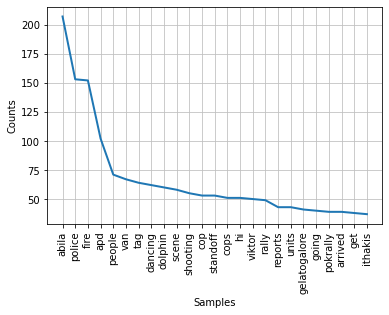

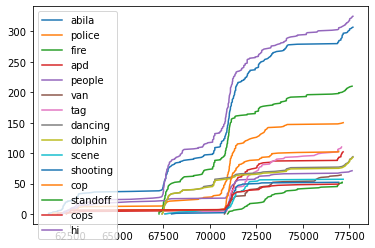

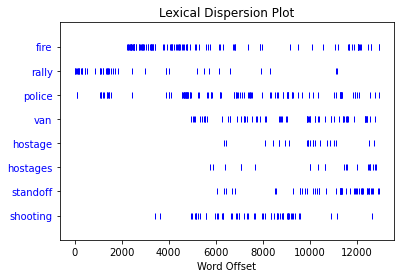

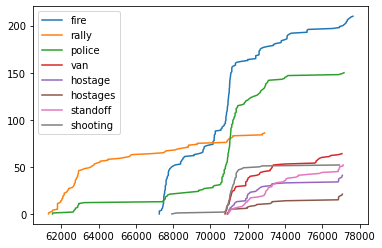

In [4]:
from nltk.tokenize import RegexpTokenizer
from nltk import FreqDist
from nltk.draw import dispersion
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('stopwords')

# tokenize text and filter out stop & forbidden words
tokenizer = RegexpTokenizer(r'\w+')
word_chunk = []
forbidden_words = ['rt', 'e']

# we don't want to track who gets retweeted the most, so add all usernames to the forbidden list
for i,e in mbdata.iterrows():
    word_chunk.extend(tokenizer.tokenize(e['message']))
    if e['author'].casefold() not in forbidden_words:
        forbidden_words.append(e['author'].casefold())
stop_words = set(stopwords.words("english"))
filtered = []
for w in word_chunk:
    if w.casefold() not in stop_words and w.casefold() not in forbidden_words:
        filtered.append(w.casefold())

# get a frequency distribution
fq = FreqDist(filtered)
fq.plot(25, cumulative=False)

# plots for the top 25
dwords = {}
for w in fq.most_common(15):
    dwords[w[0]] = []
for i,e in mbdata.iterrows():
    for k in dwords:
        rexpr = re.compile(r'.*' + k + '.*')
        match = rexpr.match(str(e['message']).casefold())
        if match:
            time = 3600*e['Hour'] + 60*e['Minute'] + e['Second']
            dwords[k].append(time)
for k in dwords:
    plt.plot(dwords[k], range(len(dwords[k])))
plt.legend(dwords.keys())
plt.show()

# plots for the selected words
plt.figure()
dwords = {'fire': [],
          'rally': [],
          'police': [],
          'van': [],
          'hostage': [],
          'hostages': [],
          'standoff': [],
          'shooting': []
         }
dispersion.dispersion_plot(word_chunk, list(dwords.keys()))
for i,e in mbdata.iterrows():
    for k in dwords:
        rexpr = re.compile(r'.*' + k + '.*')
        match = rexpr.match(str(e['message']).casefold())
        if match:
            time = 3600*e['Hour'] + 60*e['Minute'] + e['Second']
            dwords[k].append(time)
for k in dwords:
    plt.plot(dwords[k], range(len(dwords[k])))
plt.legend(dwords.keys())
plt.show()

# Identifying Level of Risk
One method of approaching this is to monitor the frequency of certain keywords associated with risk. Plots are presented for two sets of keywords. The first set of plots is for the 25 words most commonly used in the dataset. There are many seemingly mundane words in the set, but they all show a sharp rise about halfway through the time period. This suggests that emergencies create a rise in social media activity as people post about the emergency at hand. The most commonly used word in the time period was 'Abila', the site of the fire. The second set of plots represents a few words that would be indicative of danger. At the time of each accident, related words experienced an increase in usage.

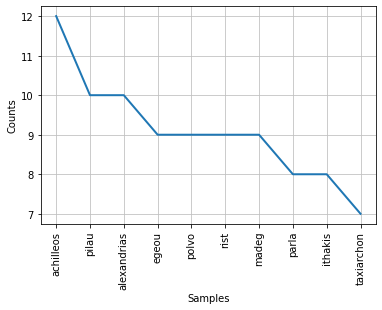

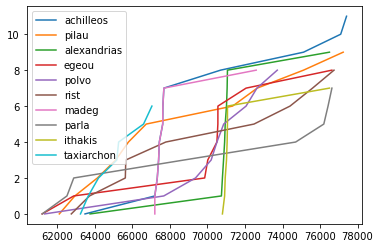

In [5]:
import matplotlib.pyplot as plt

# tokenize text
word_chunk = []
for i,e in ccdata.iterrows():
    word_chunk.extend(tokenizer.tokenize(str(e[' location'])))
filtered = []
address_words = ['n', 's', 'way', 'street', 'st', 'rd', 'way', 'ave', 'nan', 'na']
for w in word_chunk:
    if w.casefold() not in stop_words and w.casefold() not in address_words:
        filtered.append(w.casefold())

# find the most common street names among police responses
fq = FreqDist(filtered)
fq.plot(10, cumulative=False)

# find the time they occur
dwords = {}
for w in fq.most_common(10):
    dwords[w[0]] = []
for i,e in ccdata.iterrows():
    for k in dwords:
        rexpr = re.compile(r'.*' + k + '.*')
        match = rexpr.match(str(e[' location']).casefold())
        if match:
            time = 3600*e['Hour'] + 60*e['Minute'] + e['Second']
            dwords[k].append(time)
for k in dwords:
    plt.plot(dwords[k], range(len(dwords[k])))
plt.legend(dwords.keys())
plt.show()

# First Responders
By tracking the frequency of street names in the 'location' field of police reports, we can see when each location experienced a spike in report frequency. Multiple reports in a short time period are indicative of emergency situations. However, this method fails to take the type of report in regard. For example, traffic stops and drunk subjects would not be prioritized by first responders in the event of a fire or act of terrorism.

# Conclusion
NLP was a reasonably effective method of processing this data. With more time and ability, I think that more precise conclusions could have been drawn with extensions of the methods I used. However, despite my own limitations I could analyze the dataset and come to solid conclusions based on my analysis.

# Report Questions
1. Using visual analytics, characterize the different types of content in the dataset. What distinguishes meaningful event reports from typical chatter from junk or spam?  Please limit your answer to 8 images and 500 words.

As mentioned above, spam posts always include either a link or a repeated quote with the same hashtags in every post.

2. Use visual analytics to represent and evaluate how the level of the risk to the public evolves over the course of the evening. Consider the potential consequences of the situation and the number of people who could be affected.  Please limit your answer to 10 images and 1000 words.

See above for visual analytics. Risk is greatest during the two spikes in police reports, during the fire and hostage crisis.

3. If you were able to send a team of first responders to any single place, where would it be? Provide your rationale. How might your response be different if you had to respond to the events in real time rather than retrospectively? Please limit your answer to 8 images and 500 words.

I would send a team to Achilleous St. The fire created the largest amount of police reports, and is a high-risk event that should be taken care of swiftly. The hostage crisis is a far more significant and severe event, yes, but requires more of a response than first responders, and a good deal of delicacy.

4. If you solved this mini-challenge in 2014, how did you approach it differently this year?
n/a